In [4]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference')
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/svcl-oowl/brandon/research/CVPR_2021_REFINE/sil_consistent_at_inference


In [5]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import os
import re

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform
)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots

from utils import general_utils
import deformation.losses as def_losses
from utils.visualization_tools import show_refinement_results


In [6]:
def get_exp_path(exp_name):
    if os.path.exists(os.path.join("out",exp_name)):
        return exp_name
    
    if exp_name == "latest":
        exp_paths = []
        for root, dirs, files in os.walk("out"):
            for d in dirs:
                if "--" in d and len(os.path.join(root,d).split('/'))==2:
                    exp_paths.append(d)
        return sorted(exp_paths)[-1]
    
    exp_path = []
    for root, dirs, files in os.walk("out"):
        for d in dirs:
            if exp_name == d[21:] and len(os.path.join(root,d).split('/'))==2:
                exp_path.append(d)
    if len(exp_path) > 1:
        print(exp_path)
        raise Exception("multiple experiments with that name")
    elif len(exp_path) == 0:
        raise Exception("Couldn't find any matching experiments")
    else:
        return exp_path[0]

In [14]:
n="2021_01_10--12_11_33_job_02"
saved_model_path = "out/{}".format(get_exp_path(n))
print(saved_model_path)
cfg_path = general_utils.get_top_level_cfg_path(saved_model_path, "default.yaml")
print(cfg_path)
cfg = general_utils.load_config(cfg_path, "configs/default.yaml")

gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))

out/2021_01_10--12_11_33_job_02
out/2021_01_10--12_11_33_job_02/job_02.yaml


# Show Adversarial Training Info

In [16]:
df_filenames = ["train_df.pkl", "val_df.pkl"]
losses_to_show = ["sil_loss", "semantic_dis_loss"]

fig = make_subplots(rows=2, cols=len(losses_to_show), subplot_titles=["{}  {}".format(partition, loss)for partition in df_filenames for loss in losses_to_show ])
for row_i, df_filename in enumerate(df_filenames):
    df = pickle.load(open(os.path.join(saved_model_path, df_filename), "rb"))
    df_epoch_avg = df.groupby("epoch", as_index=False).mean()
    display(df_epoch_avg)

    for col_i, loss in enumerate(losses_to_show):
        loss_fig = px.line(df_epoch_avg, x="epoch", y=loss)
        loss_trace = loss_fig['data'][0]
        fig.add_trace(loss_trace, row=row_i+1, col=col_i+1)


fig.update_layout(height=700, width=700*len(losses_to_show))
fig.show()

,epoch,img_sym_loss,l2_loss,lap_smoothness_loss,normal_consistency_loss,semantic_dis_loss,sil_loss,vertex_sym_loss
0,0.0,0.0,0.000485,0.014234,0.147825,0.496972,0.0,0.0
1,5.0,0.0,0.001707,0.014075,0.108506,-1.531797,0.0,0.0
2,10.0,0.0,0.001676,0.014052,0.118915,-1.577147,0.0,0.0
3,15.0,0.0,0.001283,0.014080,0.115061,-1.779223,0.0,0.0
4,20.0,0.0,0.001294,0.013765,0.112854,-1.515499,0.0,0.0
5,25.0,0.0,0.001459,0.013609,0.117537,-0.697272,0.0,0.0
6,30.0,0.0,0.001508,0.013626,0.117083,-0.971033,0.0,0.0
7,35.0,0.0,0.001289,0.013623,0.110734,-1.158511,0.0,0.0
8,40.0,0.0,0.001519,0.013695,0.114135,-1.034180,0.0,0.0
9,45.0,0.0,0.001749,0.012897,0.119828,-0.788430,0.0,0.0


,epoch,img_sym_loss,l2_loss,lap_smoothness_loss,normal_consistency_loss,semantic_dis_loss,sil_loss,vertex_sym_loss
0,0.0,0.0,0.000489,0.014204,0.150827,0.498800,0.0,0.0
1,5.0,0.0,0.001715,0.013991,0.111314,-1.533011,0.0,0.0
2,10.0,0.0,0.001672,0.013937,0.121377,-1.572997,0.0,0.0
3,15.0,0.0,0.001262,0.013938,0.122872,-1.771970,0.0,0.0
4,20.0,0.0,0.001291,0.013628,0.121872,-1.506365,0.0,0.0
5,25.0,0.0,0.001430,0.013584,0.123053,-0.685893,0.0,0.0
6,30.0,0.0,0.001479,0.013468,0.125952,-0.953036,0.0,0.0
7,35.0,0.0,0.001252,0.013555,0.114774,-1.143422,0.0,0.0
8,40.0,0.0,0.001477,0.013529,0.122167,-1.012624,0.0,0.0
9,45.0,0.0,0.001736,0.012837,0.126354,-0.781221,0.0,0.0


# Show Adversarial Training Results

In [9]:
# displays meshes at the predicted pose
def show_meshes(cfg, device, saved_model_path, only_show_instances=[], num_novel_view=3, print_instances=False, descending=True, early_break=True):
    input_dir_img = cfg['semantic_dis_training']['gen_dir_img']
    input_dir_mesh = cfg['semantic_dis_training']['gen_dir_mesh']
    
    cached_pred_poses = pickle.load(open(cfg['semantic_dis_training']["gen_poses"], "rb"))
    
    # getting paths of all processed meshes, keyed by instance name
    processed_paths = list(Path(saved_model_path).rglob('*.obj'))
    processed_paths_dict = {}
    for path in processed_paths:
        instance_name = str(path).split('/')[-1][:-4]
        if instance_name not in processed_paths_dict:
            processed_paths_dict[instance_name] = [path]
        else:
            processed_paths_dict[instance_name].append(path)
    
    for instance_name in processed_paths_dict:
        if len(only_show_instances) == 0 or instance_name in only_show_instances:
            for processed_mesh_path in sorted(processed_paths_dict[instance_name], key= lambda x : int(re.sub("[^0-9]","",str(x).split('/')[-2])), reverse=descending):
                if print_instances:
                    print(instance_name)
                    print(processed_mesh_path)
                    
                input_image = Image.open(os.path.join(input_dir_img, instance_name+".png"))
                with torch.no_grad():
                    mesh_original = general_utils.load_untextured_mesh(os.path.join(input_dir_mesh, instance_name+".obj"), device)
                    mesh_processed = general_utils.load_untextured_mesh(processed_mesh_path, device)

                # rendering original and processed mesh at predicted pose
                pred_dist = cached_pred_poses[instance_name]['dist']
                pred_elev = cached_pred_poses[instance_name]['elev']
                pred_azim = cached_pred_poses[instance_name]['azim']
                
                show_refinement_results(input_image, mesh_original, mesh_processed, pred_dist, pred_elev, pred_azim, device)
                if early_break:
                    break

In [17]:
def show_latest_meshes(keyword):
    eval_dirs = []
    for root, dirs, files in os.walk(saved_model_path):
        for d in dirs:
            if keyword in d:
                eval_dirs.append(d)
    print(eval_dirs)
    eval_dirs = sorted(eval_dirs)
    #eval_dirs = sorted(eval_dirs, key= lambda x: int(x.replace("eval_", "")))
    latest_eval_dir = os.path.join(saved_model_path, eval_dirs[-1])
    print("Latest eval dir: {}\n".format(latest_eval_dir))

    show_meshes(cfg, device, latest_eval_dir, print_instances=True)

['eval_0055_train', 'eval_0100_train', 'eval_0015_train', 'eval_0125_train', 'eval_0060_train', 'eval_0080_train', 'eval_0000_train', 'eval_0020_train', 'eval_0070_train', 'eval_0030_train', 'eval_0045_train', 'eval_0025_train', 'eval_0005_train', 'eval_0040_train', 'eval_0090_train', 'eval_0115_train', 'eval_0010_train', 'eval_0035_train', 'eval_0105_train', 'eval_0120_train', 'eval_0065_train', 'eval_0050_train', 'eval_0085_train', 'eval_0110_train', 'eval_0095_train', 'eval_0075_train']
Latest eval dir: out/2021_01_10--12_11_33_job_02/eval_0125_train

bc140e3c54b27bfabe13ce34aa7c0c1c
out/2021_01_10--12_11_33_job_02/eval_0125_train/bc140e3c54b27bfabe13ce34aa7c0c1c.obj


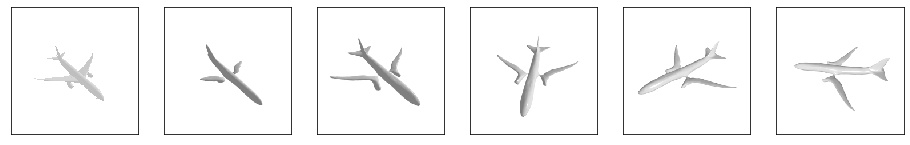

530d0edd6e2881653023dc1d1218bb2d
out/2021_01_10--12_11_33_job_02/eval_0125_train/530d0edd6e2881653023dc1d1218bb2d.obj


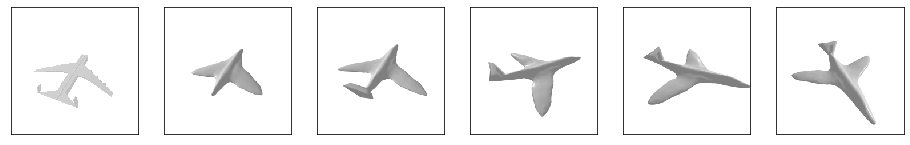

41afa42c77cd167c2b5147716975ed8a
out/2021_01_10--12_11_33_job_02/eval_0125_train/41afa42c77cd167c2b5147716975ed8a.obj


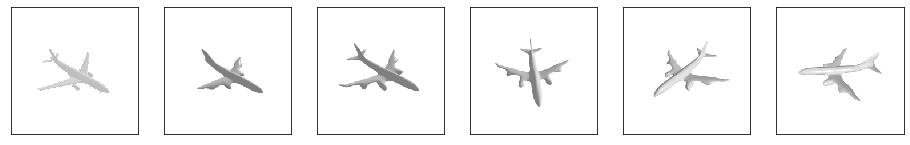

7c4e1ab21e8d6549a46ec065c01b381
out/2021_01_10--12_11_33_job_02/eval_0125_train/7c4e1ab21e8d6549a46ec065c01b381.obj


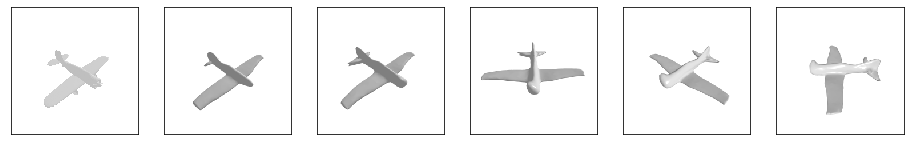

6d119be1286c7b129a6e43b878d5b335
out/2021_01_10--12_11_33_job_02/eval_0125_train/6d119be1286c7b129a6e43b878d5b335.obj


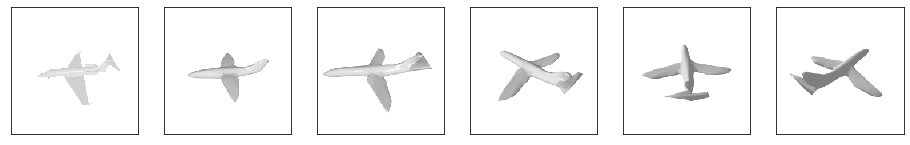

641af2da275049936cc53f9d72e7fec3
out/2021_01_10--12_11_33_job_02/eval_0125_train/641af2da275049936cc53f9d72e7fec3.obj


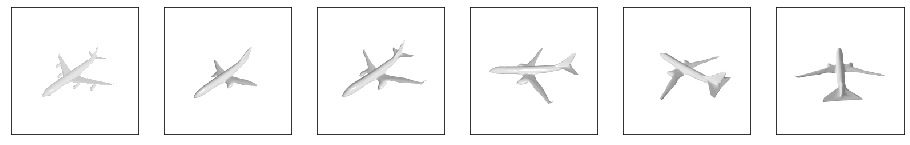

7f2d03635180db2137678474be485ca
out/2021_01_10--12_11_33_job_02/eval_0125_train/7f2d03635180db2137678474be485ca.obj


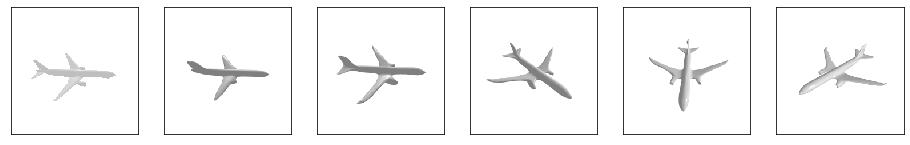

80b8f4da6b77eb66d208f79049825a82
out/2021_01_10--12_11_33_job_02/eval_0125_train/80b8f4da6b77eb66d208f79049825a82.obj


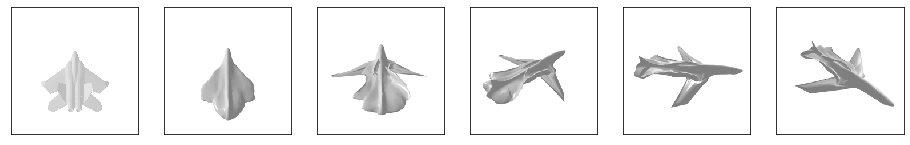

5b815e2726656685823df672991ed66
out/2021_01_10--12_11_33_job_02/eval_0125_train/5b815e2726656685823df672991ed66.obj


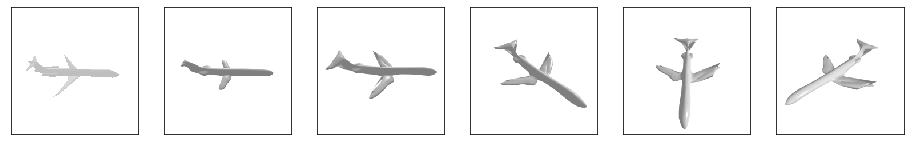

c47954200b78fc32f677dde7945cba25
out/2021_01_10--12_11_33_job_02/eval_0125_train/c47954200b78fc32f677dde7945cba25.obj


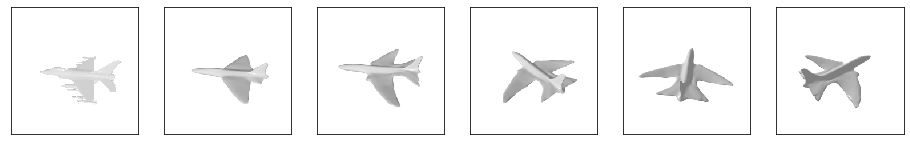

ce0c461237a21cefdb22b838c125a50b
out/2021_01_10--12_11_33_job_02/eval_0125_train/ce0c461237a21cefdb22b838c125a50b.obj


KeyboardInterrupt: 

In [18]:
show_latest_meshes("_train")

['eval_0010_val', 'eval_0120_val', 'eval_0075_val', 'eval_0070_val', 'eval_0095_val', 'eval_0065_val', 'eval_0050_val', 'eval_0020_val', 'eval_0035_val', 'eval_0110_val', 'eval_0060_val', 'eval_0015_val', 'eval_0040_val', 'eval_0115_val', 'eval_0045_val', 'eval_0090_val', 'eval_0080_val', 'eval_0085_val', 'eval_0125_val', 'eval_0100_val', 'eval_0055_val', 'eval_0105_val', 'eval_0005_val', 'eval_0000_val', 'eval_0030_val', 'eval_0025_val']
Latest eval dir: out/2021_01_10--12_11_33_job_02/eval_0125_val

18d994c4f8362cfaee9d01b4b18e1b2f
out/2021_01_10--12_11_33_job_02/eval_0125_val/18d994c4f8362cfaee9d01b4b18e1b2f.obj


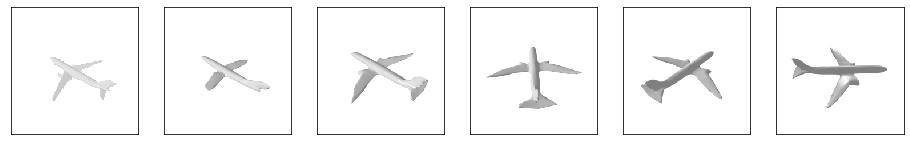

13370c42b8ea45cf5e8172e6d9ae84ff
out/2021_01_10--12_11_33_job_02/eval_0125_val/13370c42b8ea45cf5e8172e6d9ae84ff.obj


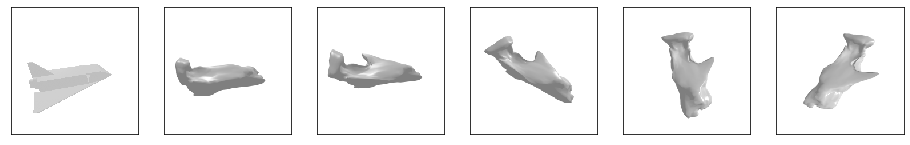

106dfe858cb8fbc2afc6b80d80a265ab
out/2021_01_10--12_11_33_job_02/eval_0125_val/106dfe858cb8fbc2afc6b80d80a265ab.obj


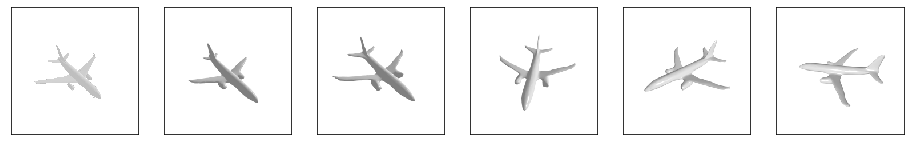

1492ab4cf7a345e34b6f686803e61ffd
out/2021_01_10--12_11_33_job_02/eval_0125_val/1492ab4cf7a345e34b6f686803e61ffd.obj


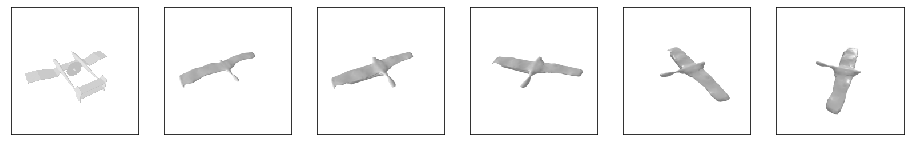

17ad3ab1b1d12a7db26dc8ec64d633df
out/2021_01_10--12_11_33_job_02/eval_0125_val/17ad3ab1b1d12a7db26dc8ec64d633df.obj


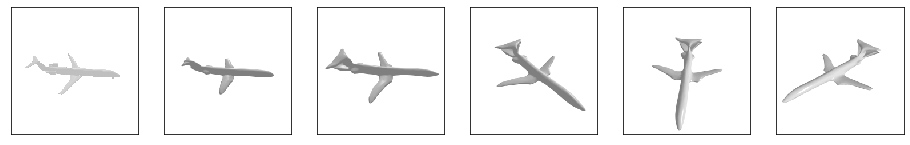

151550551758af098b96ae1a0a8b84ec
out/2021_01_10--12_11_33_job_02/eval_0125_val/151550551758af098b96ae1a0a8b84ec.obj


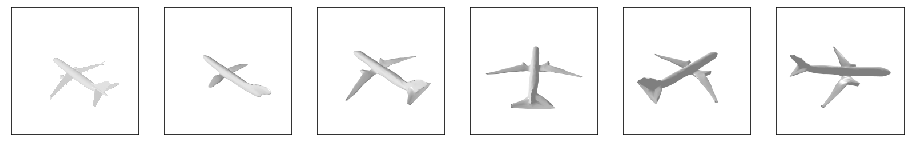

10c7cdfdffe2243b88a89a28f04ce622
out/2021_01_10--12_11_33_job_02/eval_0125_val/10c7cdfdffe2243b88a89a28f04ce622.obj


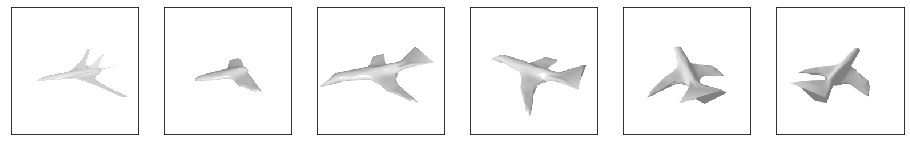

177fadcfa6b4a8346aa3bf023a2b42a5
out/2021_01_10--12_11_33_job_02/eval_0125_val/177fadcfa6b4a8346aa3bf023a2b42a5.obj


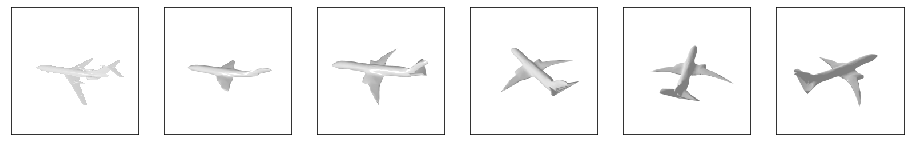

1930a979c7a9a2d662b600da24e0965
out/2021_01_10--12_11_33_job_02/eval_0125_val/1930a979c7a9a2d662b600da24e0965.obj


KeyboardInterrupt: 

In [19]:
show_latest_meshes("_val")

18d994c4f8362cfaee9d01b4b18e1b2f
out/2021_01_10--12_11_09_job_01/eval_0235_val/18d994c4f8362cfaee9d01b4b18e1b2f.obj


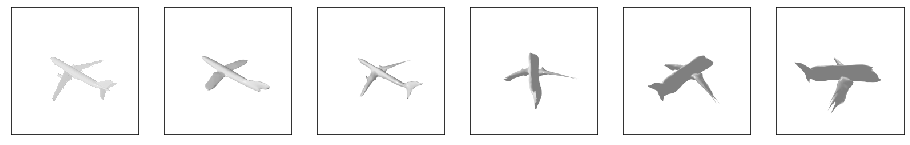

13370c42b8ea45cf5e8172e6d9ae84ff
out/2021_01_10--12_11_09_job_01/eval_0235_val/13370c42b8ea45cf5e8172e6d9ae84ff.obj


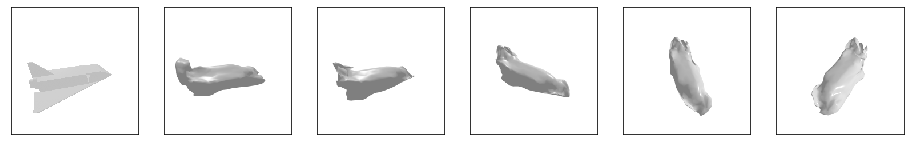

106dfe858cb8fbc2afc6b80d80a265ab
out/2021_01_10--12_11_09_job_01/eval_0235_val/106dfe858cb8fbc2afc6b80d80a265ab.obj


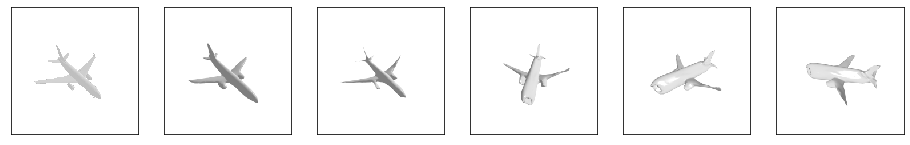

1492ab4cf7a345e34b6f686803e61ffd
out/2021_01_10--12_11_09_job_01/eval_0235_val/1492ab4cf7a345e34b6f686803e61ffd.obj


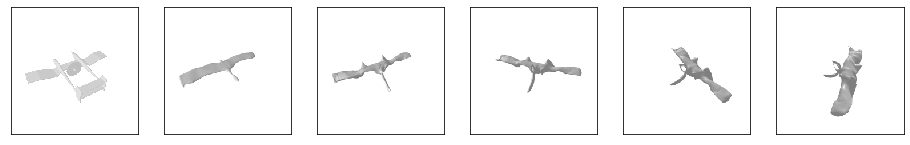

17ad3ab1b1d12a7db26dc8ec64d633df
out/2021_01_10--12_11_09_job_01/eval_0235_val/17ad3ab1b1d12a7db26dc8ec64d633df.obj


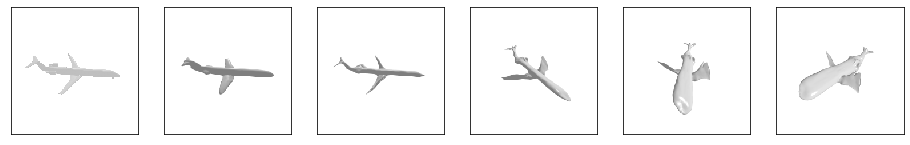

151550551758af098b96ae1a0a8b84ec
out/2021_01_10--12_11_09_job_01/eval_0235_val/151550551758af098b96ae1a0a8b84ec.obj


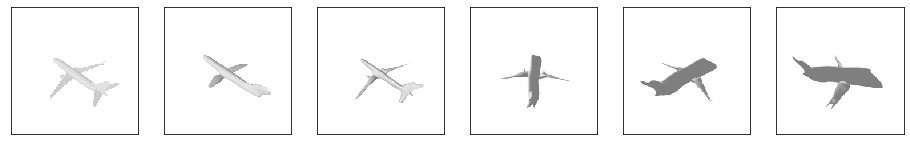

10c7cdfdffe2243b88a89a28f04ce622
out/2021_01_10--12_11_09_job_01/eval_0235_val/10c7cdfdffe2243b88a89a28f04ce622.obj


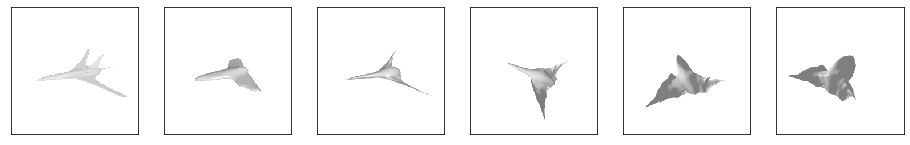

177fadcfa6b4a8346aa3bf023a2b42a5
out/2021_01_10--12_11_09_job_01/eval_0235_val/177fadcfa6b4a8346aa3bf023a2b42a5.obj


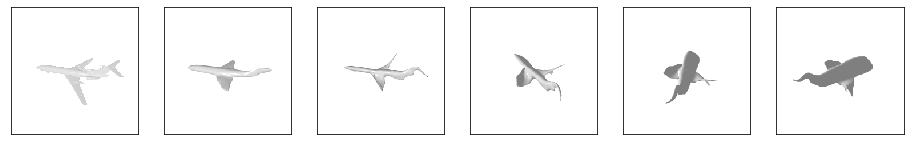

1930a979c7a9a2d662b600da24e0965
out/2021_01_10--12_11_09_job_01/eval_0235_val/1930a979c7a9a2d662b600da24e0965.obj


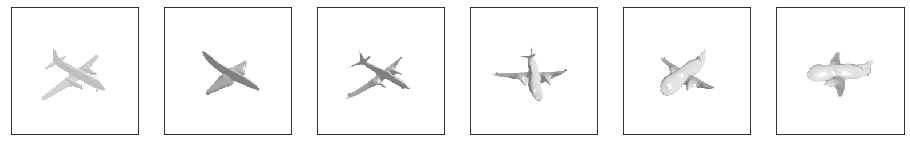

18d123aaef6b911954eefcdc602d4520
out/2021_01_10--12_11_09_job_01/eval_0235_val/18d123aaef6b911954eefcdc602d4520.obj


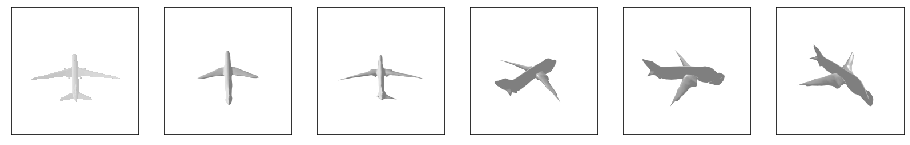

14d9c576d06622198f52dc705c3109b9
out/2021_01_10--12_11_09_job_01/eval_0235_val/14d9c576d06622198f52dc705c3109b9.obj


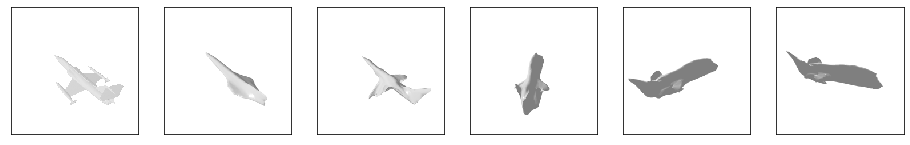

195ca2eabbf7c735a8d66821ccb813fe
out/2021_01_10--12_11_09_job_01/eval_0235_val/195ca2eabbf7c735a8d66821ccb813fe.obj


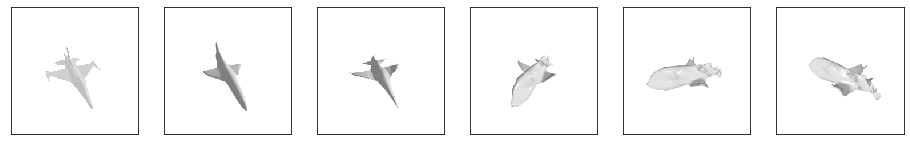

133937bd45f953748be6919d4632fec1
out/2021_01_10--12_11_09_job_01/eval_0235_val/133937bd45f953748be6919d4632fec1.obj


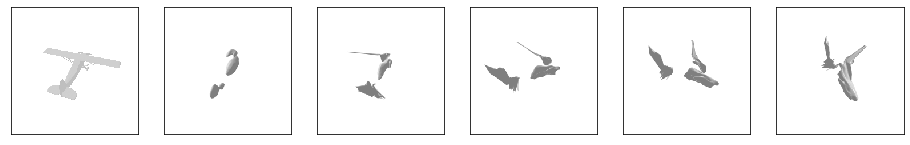

1345cd9d0da6d149c6f6da58b133bae0
out/2021_01_10--12_11_09_job_01/eval_0235_val/1345cd9d0da6d149c6f6da58b133bae0.obj


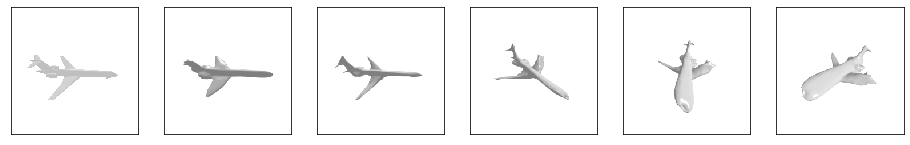

1284eb71b82f6794207f77cc6c79e3d5
out/2021_01_10--12_11_09_job_01/eval_0235_val/1284eb71b82f6794207f77cc6c79e3d5.obj


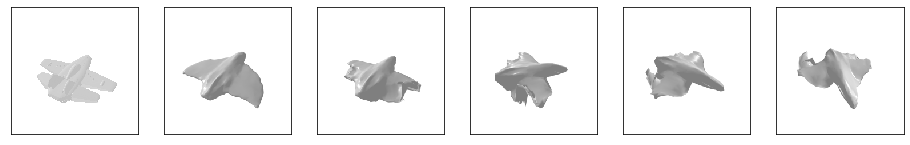

132111c575000a3c146e44cc99f07c52
out/2021_01_10--12_11_09_job_01/eval_0235_val/132111c575000a3c146e44cc99f07c52.obj


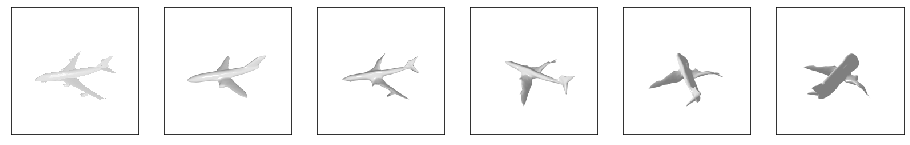

10e4331c34d610dacc14f1e6f4f4f49b
out/2021_01_10--12_11_09_job_01/eval_0235_val/10e4331c34d610dacc14f1e6f4f4f49b.obj


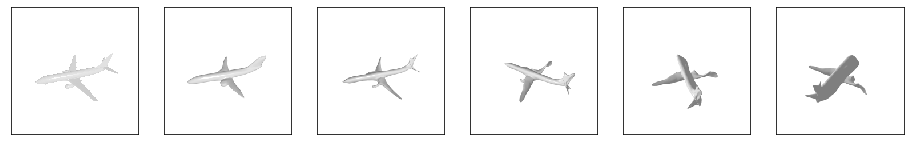

14453b29e139d81f6d07c55cf995503e
out/2021_01_10--12_11_09_job_01/eval_0235_val/14453b29e139d81f6d07c55cf995503e.obj


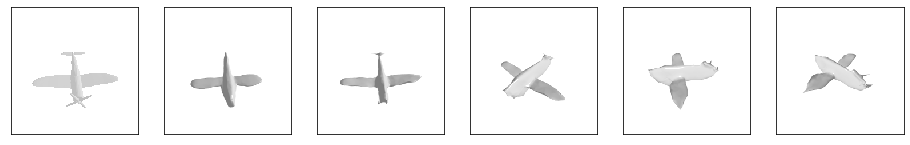

124a579e0635b8eace19d55bc5e6a406
out/2021_01_10--12_11_09_job_01/eval_0235_val/124a579e0635b8eace19d55bc5e6a406.obj


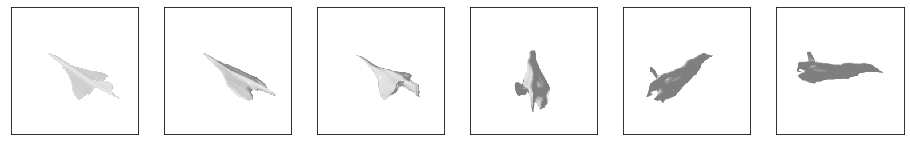

1367266dc0a07c925d4533028830a79b
out/2021_01_10--12_11_09_job_01/eval_0235_val/1367266dc0a07c925d4533028830a79b.obj


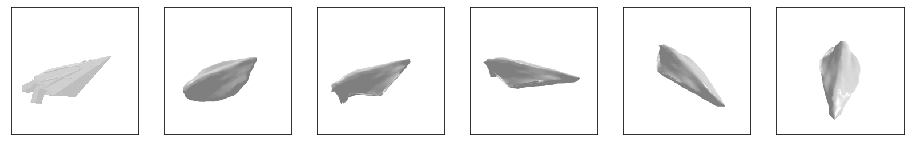

12991e9529a2b2bf9ac9930d2147598f
out/2021_01_10--12_11_09_job_01/eval_0235_val/12991e9529a2b2bf9ac9930d2147598f.obj


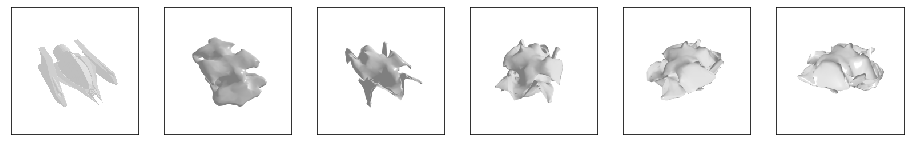

18f5265d553d72fb6b7bd17e458d0dcb
out/2021_01_10--12_11_09_job_01/eval_0235_val/18f5265d553d72fb6b7bd17e458d0dcb.obj


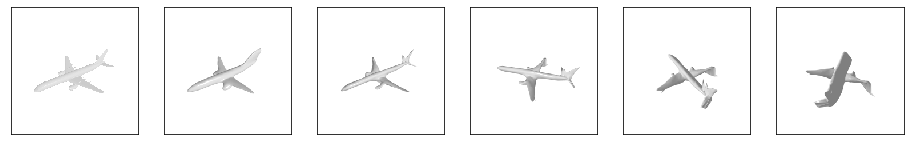

162ed8d0d989f3acc1ccec171a275967
out/2021_01_10--12_11_09_job_01/eval_0235_val/162ed8d0d989f3acc1ccec171a275967.obj


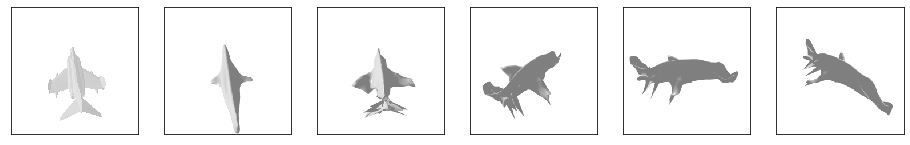

19604020a86ab1790b1d6deb98feec6
out/2021_01_10--12_11_09_job_01/eval_0235_val/19604020a86ab1790b1d6deb98feec6.obj


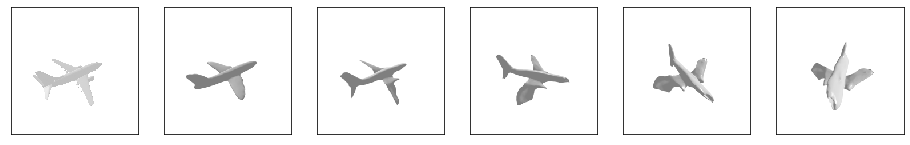

172ac13acd9aa91f3df325aac2f73830
out/2021_01_10--12_11_09_job_01/eval_0235_val/172ac13acd9aa91f3df325aac2f73830.obj


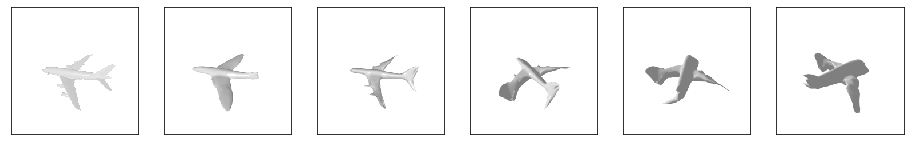

1304ef60fe9793f685e0a2007a11e92f
out/2021_01_10--12_11_09_job_01/eval_0235_val/1304ef60fe9793f685e0a2007a11e92f.obj


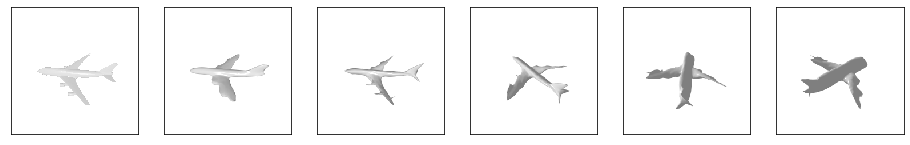

1890f6391df25286394b1e418d5c594
out/2021_01_10--12_11_09_job_01/eval_0235_val/1890f6391df25286394b1e418d5c594.obj


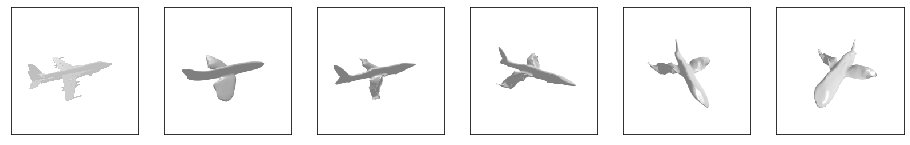

16689e54c884aa01639c7058eaf33ae
out/2021_01_10--12_11_09_job_01/eval_0235_val/16689e54c884aa01639c7058eaf33ae.obj


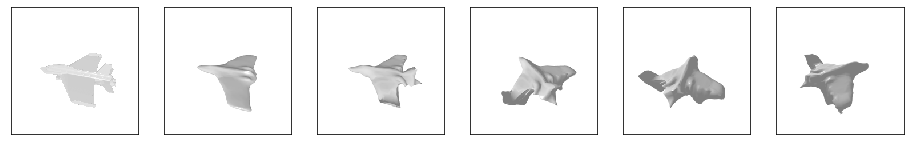

105f7f51e4140ee4b6b87e72ead132ed
out/2021_01_10--12_11_09_job_01/eval_0235_val/105f7f51e4140ee4b6b87e72ead132ed.obj


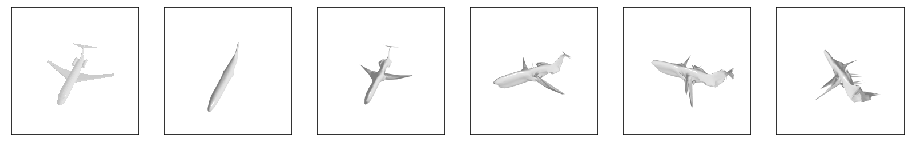

10155655850468db78d106ce0a280f87
out/2021_01_10--12_11_09_job_01/eval_0235_val/10155655850468db78d106ce0a280f87.obj


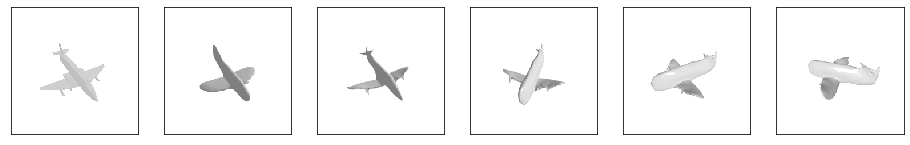

186ca7892ed6de2adb22b838c125a50b
out/2021_01_10--12_11_09_job_01/eval_0235_val/186ca7892ed6de2adb22b838c125a50b.obj


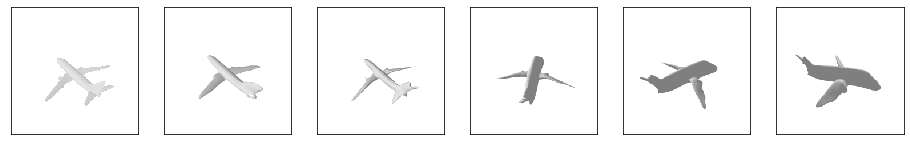

17c2d3e052dfe73f9cc1fc25372199f
out/2021_01_10--12_11_09_job_01/eval_0235_val/17c2d3e052dfe73f9cc1fc25372199f.obj


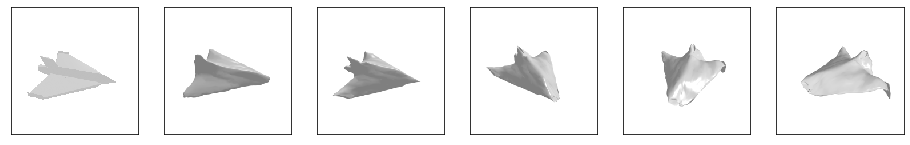

1856da25a85402ce63e266a803d9270
out/2021_01_10--12_11_09_job_01/eval_0235_val/1856da25a85402ce63e266a803d9270.obj


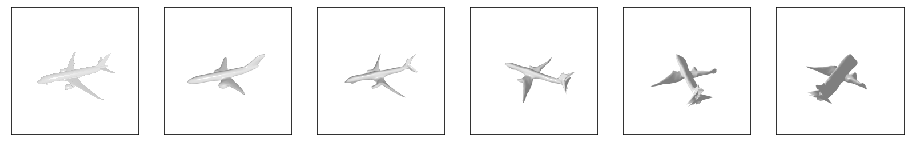

1943ee06ecb139819330265a9fff38de
out/2021_01_10--12_11_09_job_01/eval_0235_val/1943ee06ecb139819330265a9fff38de.obj


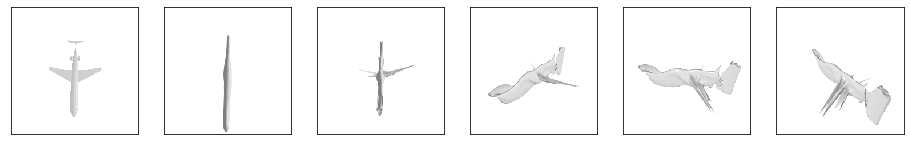

18806a80387734b754c7b6e11bf7148d
out/2021_01_10--12_11_09_job_01/eval_0235_val/18806a80387734b754c7b6e11bf7148d.obj


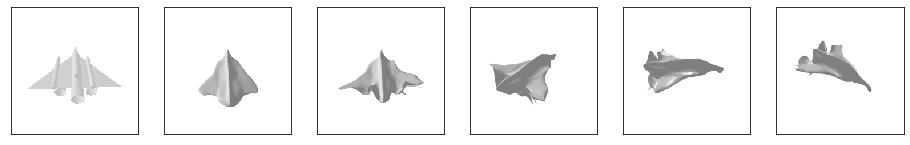

1496504f42de2eef8b96ae1a0a8b84ec
out/2021_01_10--12_11_09_job_01/eval_0235_val/1496504f42de2eef8b96ae1a0a8b84ec.obj


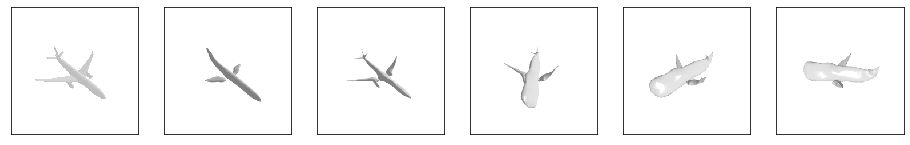

14d6bbabad3ad00dbbf3143b1cb6076a
out/2021_01_10--12_11_09_job_01/eval_0235_val/14d6bbabad3ad00dbbf3143b1cb6076a.obj


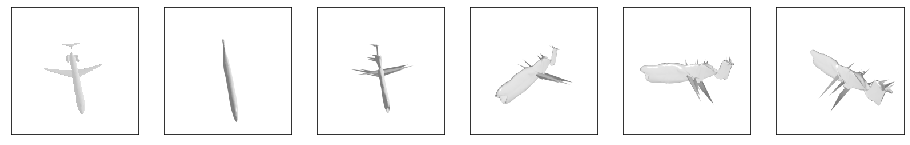

18666bda4244d22ca7aff2c3136e8e59
out/2021_01_10--12_11_09_job_01/eval_0235_val/18666bda4244d22ca7aff2c3136e8e59.obj


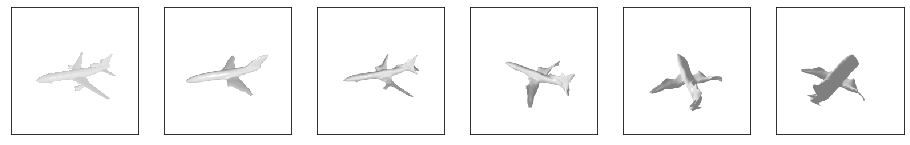

1397f5bfd89673b21fc43d5b32fa230f
out/2021_01_10--12_11_09_job_01/eval_0235_val/1397f5bfd89673b21fc43d5b32fa230f.obj


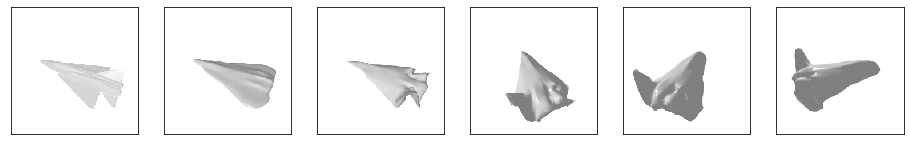

18e86ba0172154f3bc0909d98a1ff2b4
out/2021_01_10--12_11_09_job_01/eval_0235_val/18e86ba0172154f3bc0909d98a1ff2b4.obj


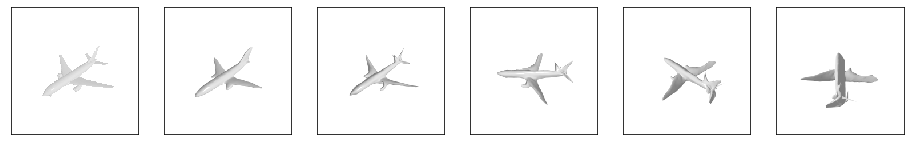

In [13]:
show_meshes(cfg, device, "out/2021_01_10--12_11_09_job_01/eval_0235_val", print_instances=True)

In [ ]:
# show a mesh throughout iterations
#instances_to_show = ["ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749"]
#instances_to_show = ["e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]
instances_to_show = ["d30e58a2361785683fb0851e9bc87551", "cc25ba35b3f6e8d3d064b65ccd89778c", "d4326cd55ed8333f6a059e1fc701f06", "d02f9ae175fa83d3e6fe3612af521500", "d1291956cb0983ee7085b4353236aad",
            "ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749",
            "e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]

show_meshes(cfg, device, saved_model_path, instances_to_show, print_instances=True, descending=True)

# New heading

In [ ]:
for i in range(1,19):
    n = ("job_{:02}".format(i))
    saved_model_path = "out/{}".format(get_exp_path(n))
    print(saved_model_path)
    cfg_path = glob.glob(os.path.join(saved_model_path, "job_*.yaml"))[0]
    print(cfg_path)
    cfg = general_utils.load_config(cfg_path, "configs/default.yaml")
    
    # show a mesh throughout iterations
    #instance_to_show = ["ee4858f78dc33591100e9bd5c4b0af54", "e0efbc4e240b9cc235836c728d324152", "d6ac690c293a492d2d2a5d4c4022b4c6", "d20de927fd1b15ef104c86562c321749"]
    instance_to_show = ["e7d4a3cca8edfde4829113e62386fd50", "d97a4a6f84f40854f51fa0238791f5dc", "ce9cedc58c77aab4b5a19b1840ec7af"]
    show_meshes(cfg, device, saved_model_path, instance_to_show, print_instances=True, descending=True)

    print("=================================================================================================")
    print("=================================================================================================")